In [1]:
import pandas as pd
import geopandas as gp
import skmob
from skmob.measures.individual import radius_of_gyration, number_of_locations
import random
from tqdm.notebook import tqdm
tqdm.pandas()
import math
import matplotlib.pyplot as plt
import seaborn as sns
import math
from shapely import Point
from statannotations.Annotator import Annotator
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':200})
sns.set_palette(sns.color_palette("colorblind"))


import sys
sys.path.append('..')

import attack

In [9]:
# load data
# freemove = gp.read_file("data/freemove/freemove_clustering_tfidf.geojson", geometry='geometry')
# freemove_private = gp.read_file("data/freemove/freemove_private_clustering_tfidf.geojson", geometry='geometry')
# freemove_500tessellation = gp.read_file("data/freemove/freemove_500tessellation_clustering_tfidf.geojson", geometry='geometry')
# freemove_private_500tessellation = gp.read_file("data/freemove/freemove_private_500tessellation_clustering_tfidf.geojson", geometry='geometry')

geolife = gp.read_file("data/geolife/geolife_clustering_tfidf.geojson", geometry='geometry')
# geolife_private = gp.read_file("data/geolife/geolife_private_clustering_tfidf.geojson", geometry='geometry')


clustering_results = {
    'freemove': freemove,
    'freemove_private': freemove_private,
    'freemove_500tessellation': freemove_500tessellation,
    'freemove_private_500tessellation': freemove_private_500tessellation,
    'geolife': geolife,
    'geolife_private': geolife_private,
}

In [21]:
clustering_results

{'freemove':       TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
 0           0  2022-10-21T14:59:24  2022-10-21T15:25:01       6370.874696   
 1           1  2022-10-21T16:07:38  2022-10-21T16:43:11        396.033850   
 2           2  2022-10-21T19:16:16  2022-10-21T19:32:46       4679.385964   
 3           3  2022-10-21T20:41:59  2022-10-21T21:29:28      13123.732328   
 4           4  2022-10-23T09:32:44  2022-10-23T10:01:43       2060.403029   
 ...       ...                  ...                  ...               ...   
 1181     1403  2022-11-17T17:47:36  2022-11-17T18:13:33       9080.651164   
 1182     1404  2022-11-17T18:25:39  2022-11-17T18:35:06        287.824158   
 1183     1405  2022-11-17T18:55:08  2022-11-17T19:17:50       7049.781622   
 1184     1406  2022-11-17T20:59:11  2022-11-17T21:02:04        491.586878   
 1185     1407  2022-11-17T22:04:14  2022-11-17T22:20:54       7724.704564   
 
       PERSON_ID   TRIP_WD   TRIP_DATE  TRIP_DURAT

In [10]:
attack.evaluate(geolife.clustering_HL.tolist(), geolife)

Homogeneity: 0.847
Completeness: 0.511
V-measure: 0.638
Rand index: 0.968
ARI: 0.266
MI: 3.134
NMI: 0.638
AMI: 0.421
Cluster accuracy: 0.317


In [12]:
def compute_perf_scores(clustering_result_data, uid, n_points):
    # get for random points from this user's trajectories
    coords = [list(x.coords) for x in clustering_result_data.query('PERSON_ID == @uid').geometry.tolist()]
    coords = [item for sublist in coords for item in sublist]
    rand_points = random.choices(coords, k=n_points)

    # find all trajectories where these points are part of and get unique cluster ids
    clustering_result_data['contains_rand_points'] = clustering_result_data.geometry.apply(lambda x: 1 if len(set(x.coords).intersection(set(rand_points))) > 0 else 0)
    cluster_ids = clustering_result_data.query('contains_rand_points == 1').clustering_HL.unique()

    # get trips of cluster and the true nr of trips of this user
    cluster_trips = clustering_result_data.query('clustering_HL in @cluster_ids')
    n_cluster_trips = len(cluster_trips)
    n_cluster_user_trips = len(cluster_trips.query('PERSON_ID == @uid'))
    n_user_trips = len(clustering_result_data.query('PERSON_ID == @uid'))

    # calculate precision, recall, mean
    precision = n_cluster_user_trips/n_cluster_trips
    recall = n_cluster_user_trips/n_user_trips
    pr_mean = (precision + recall)/2
    f_score = 2*((precision*recall)/(precision+recall))

    return precision, recall, pr_mean, f_score


def evaluate_attack(clustering_result_data, n_draws_per_user, nr_points):
    eval_scores = {'user_id': [], 'precision': [], 'recall': [], 'pr_mean': [], 'f_score': [], 'nr_points': []}
    
    # Find user ids that have at least N_POINTS + 1 trips
    user_ids = clustering_result_data.groupby('PERSON_ID').TRIP_ID.nunique().reset_index().query('TRIP_ID > @nr_points').PERSON_ID.unique()
    print('Nr of users to evaluate: ', user_ids.size)
    
    # only evaluate user that have at least N_POINTS/2 + 1 trips
    for uid in tqdm(user_ids):
    
        precision_scores, recall_scores, pr_mean_scores, f_scores = [], [], [], []
        for i in range(n_draws_per_user):
            p, r, m, f = compute_perf_scores(clustering_result_data, uid, nr_points)
            precision_scores.append(p)
            recall_scores.append(r)
            pr_mean_scores.append(m)
            f_scores.append(f)

        eval_scores['user_id'].extend([uid] * len(precision_scores))
        eval_scores['precision'].extend(precision_scores)
        eval_scores['recall'].extend(recall_scores)
        eval_scores['pr_mean'].extend(pr_mean_scores)
        eval_scores['f_score'].extend(f_scores)
        eval_scores['nr_points'].extend([nr_points] * len(precision_scores))

    return pd.DataFrame.from_dict(eval_scores)

scores = []
for name, data in clustering_results.items():
    if name != "geolife":
        continue
    print("Next dataset: ", name)
    scores_points = []
    for nr_p in [1,4,10]:
        scores_points.append(evaluate_attack(data, n_draws_per_user=10, nr_points=nr_p))
    scores.append(pd.concat(scores_points))
    
# scores = pd.concat(scores, keys=list(clustering_results.keys())).reset_index(0, names="data")

Next dataset:  geolife
Nr of users to evaluate:  69


  0%|          | 0/69 [00:00<?, ?it/s]

Nr of users to evaluate:  59


  0%|          | 0/59 [00:00<?, ?it/s]

Nr of users to evaluate:  54


  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='nr_points', ylabel='precision'>

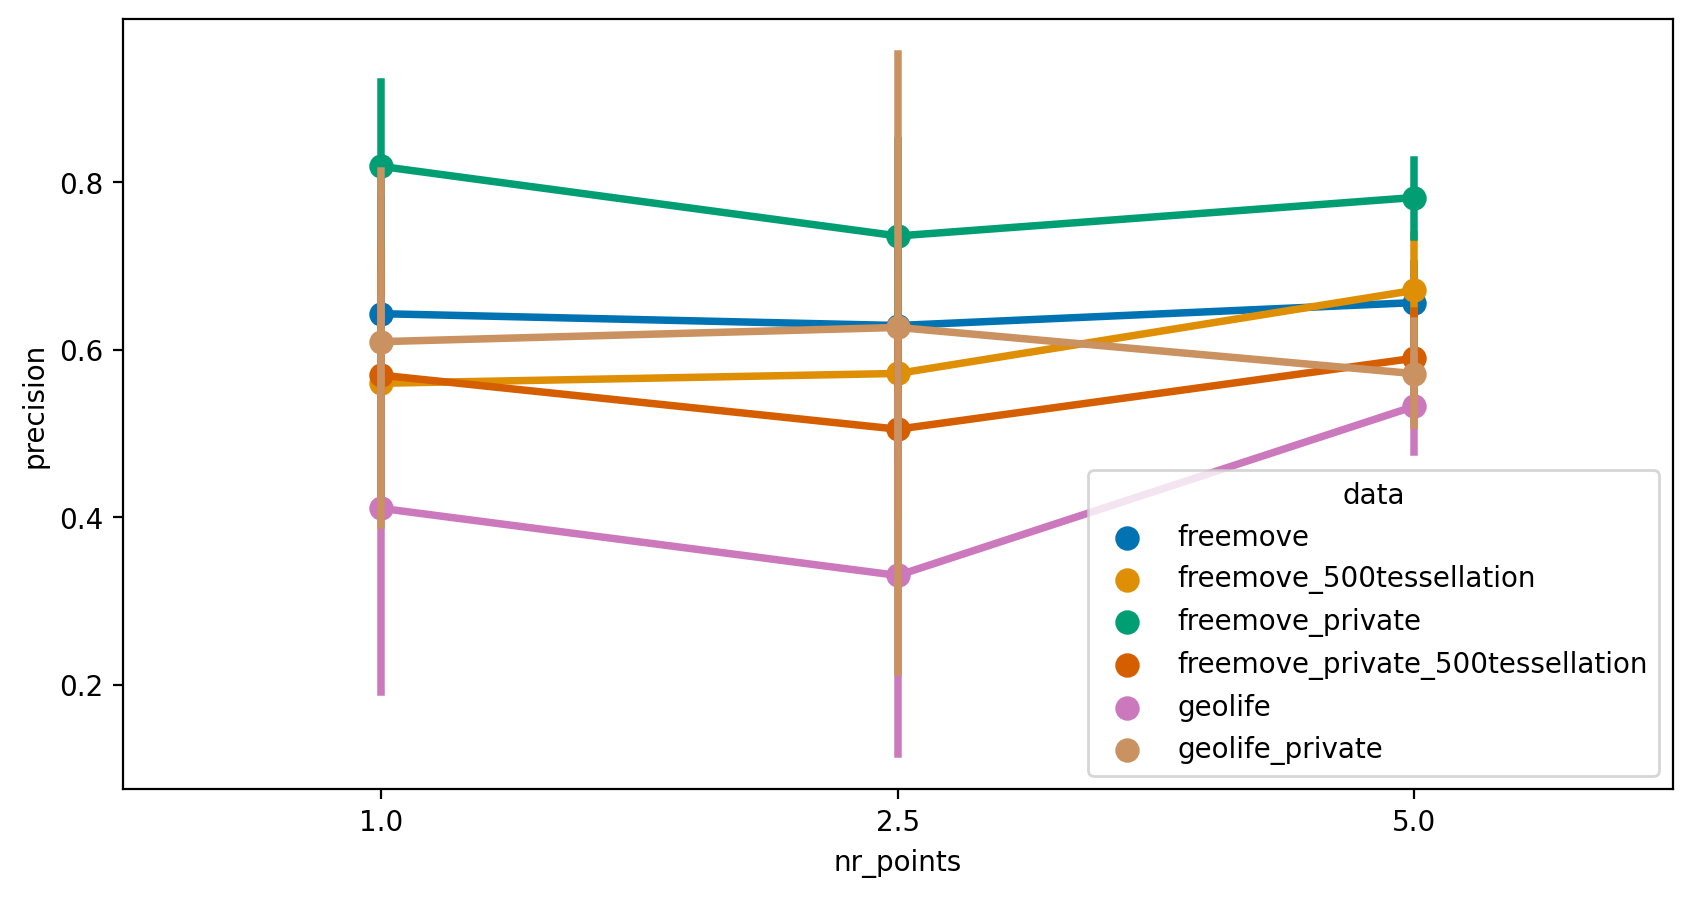

In [52]:
sns.pointplot(x="nr_points", y="precision", data=scores, hue="data")

# Constructing Covariates

In [58]:
def get_points(gdf, tessellation):
    gdf = gdf.to_crs(4326)
    gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
    gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))
    
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points



def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_id == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le

In [67]:
# Entropy freemove
i = 0
tessellation_freemove = gp.read_file("data/freemove/tessellation_freemove_500.geojson", geometry='geometry').to_crs(4326)
for name, data in clustering_results.items():
    if i > 3:
        break
    print(name)
    
    # Get random entropy
    re = get_points(data, tessellation_freemove).groupby('PERSON_ID').apply(lambda g: math.log2(g.tile_id.nunique())).reset_index().rename(columns={0: 'rand_entropy', 'PERSON_ID': 'user_id'})
    scores[i] = pd.merge(scores[i], re, how='left')
    
    # Get average location entropy
    mapped_points_gdf = get_points(data, tessellation_freemove)
    mapped_points_gdf['ale'] = mapped_points_gdf.tile_id.progress_apply(lambda x: get_location_entropy(x, mapped_points_gdf))
    scores[i] = pd.merge(scores[i], mapped_points_gdf[['PERSON_ID', 'ale']].groupby('PERSON_ID').mean().reset_index().rename(columns={'PERSON_ID': 'user_id'}), how='left')
    
    i += 1

freemove


In [ ]:
# Entropy GeoLife
i = 4
tessellation_geolife = gp.read_file("data/geolife/geolife_freemove_500.geojson", geometry='geometry').to_crs(4326)
for name, data in clustering_results.items():
    print(name)
    # Get random entropy
    re = get_points(data, tessellation_geolife).groupby('PERSON_ID').apply(lambda g: math.log2(g.tile_id.nunique())).reset_index().rename(columns={0: 'rand_entropy', 'PERSON_ID': 'user_id'})
    scores[i] = pd.merge(scores[i], re, how='left')
    
    # Get average location entropy
    mapped_points_gdf = get_points(data, tessellation_geolife)
    mapped_points_gdf['ale'] = mapped_points_gdf.tile_id.progress_apply(lambda x: get_location_entropy(x, mapped_points_gdf))
    scores[i] = pd.merge(scores[i], mapped_points_gdf[['PERSON_ID', 'ale']].groupby('PERSON_ID').mean().reset_index().rename(columns={'PERSON_ID': 'user_id'}), how='left')
    
    i += 1

In [ ]:
# N_trips per user
for index, (name, data) in enumerate(clustering_results.items()):
    print(name)
    scores[index] = pd.merge(scores[index], data.groupby('PERSON_ID').TRIP_ID.nunique().reset_index().rename(columns={'TRIP_ID': 'n_trips', 'PERSON_ID': 'user_id'}), how='left')


In [74]:
# Radius of gyration freemove
freemove_raw_points = gp.read_file("data/freemove/freemove_raw_point.geojson", geometry='geometry')
freemove_raw_points = freemove_raw_points.to_crs(4326)
freemove_raw_points['lon'] = freemove_raw_points.geometry.apply(lambda x: x.coords[0][0])
freemove_raw_points['lat'] = freemove_raw_points.geometry.apply(lambda x: x.coords[0][1])
tdf_freemove = skmob.TrajDataFrame(freemove_raw_points, latitude='lat', longitude='lon', datetime='time', user_id='user')
rg = radius_of_gyration(tdf_freemove)

for data in scores[:4]:
    data = pd.merge(data, rg.rename(columns={'uid': 'user_id'}), how='left')


  0%|          | 0/74 [00:00<?, ?it/s]

In [77]:
# Radius of gyration freemove
geolife_raw_points = gp.read_file("data/geolife/geolife_raw_point.geojson", geometry='geometry')
geolife_raw_points = geolife_raw_points.to_crs(4326)
geolife_raw_points['lon'] = geolife_raw_points.geometry.apply(lambda x: x.coords[0][0])
geolife_raw_points['lat'] = geolife_raw_points.geometry.apply(lambda x: x.coords[0][1])
tdf_geolife = skmob.TrajDataFrame(geolife_raw_points, latitude='lat', longitude='lon', datetime='time', user_id='user')
rg = radius_of_gyration(tdf_geolife)

# for data in scores[4:]:
#     data = pd.merge(data, rg.rename(columns={'uid': 'user_id'}), how='left')


NameError: name 'tdf_geolife' is not defined

In [76]:
[0,1,2,3,4,5,6,7][4:]

[4, 5, 6, 7]

In [ ]:
# Mean hour of day 
for index, (name, data) in enumerate(clustering_results.items()):
    print(name)
    data['hour_of_day'] = pd.to_datetime(data.TRIP_START).dt.hour - 1
    scores[index] = pd.merge(scores[index], data[['PERSON_ID', 'hour_of_day']].groupby('PERSON_ID').mean().reset_index().rename(columns={'PERSON_ID': 'user_id'}), how='left')
